In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import re
import gc
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix, plot_roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import chi2
from yellowbrick.cluster import KElbowVisualizer
from lightgbm import LGBMRegressor, LGBMClassifier
import lightgbm as lgbm
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.frequent_patterns import apriori, association_rules
from tqdm import tqdm
from hcuppy.ccs import CCSEngine
from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.float_format', lambda num:'%1.3f'%num)
pd.set_option('display.max_columns', 99)

In [3]:
MEMBERS = pd.read_csv('MEMBERS_table.csv', parse_dates=['MemberDOB', 'MemberDeathDate'])
CLMS_2021 = pd.read_csv('CLM_table 2021.csv', parse_dates=['ClaimBeginDate', 'ClaimEndDate'])
CLMS_2020 = pd.read_csv('CLM_table 2020.csv', parse_dates=['ClaimBeginDate', 'ClaimEndDate'])
CLMS_2019 = pd.read_csv('CLM_table 2019.csv', parse_dates=['ClaimBeginDate', 'ClaimEndDate'])
CLMS_2018 = pd.read_csv('CLM_table 2018.csv', parse_dates=['ClaimBeginDate', 'ClaimEndDate'])
CLMS_2017 = pd.read_csv('CLM_table 2017.csv', parse_dates=['ClaimBeginDate', 'ClaimEndDate'])

## 1. Feature Engineering

In [4]:
def concatenate_object_label(df, column):
    
    """
    Concat labels to string
    """
    
    temp_df = df[['MemberID', column]].dropna()
    temp_df[column] = temp_df[column].astype(str).str.strip(' ')
    result_df = temp_df.drop_duplicates().groupby( ['MemberID'], as_index=False).agg({column: ','.join})
    
    return result_df

In [5]:
def making_final_df(CLMS, MEMBERS):
    
    """
    Make final dataframe for training
    """
    
    clms_drop = ['ClaimID', 'ClaimProviderID', 'FacilityProviderNPI', 'AttendingProviderID', 'ClaimTypeDescription', 'AdmissionStatus',
                       'EmergencyStatus', 'ReadmissionStatus', 'OPERIND', 'OPOBSIND', 'SNFADMIND',
                       'HOSPADMIND', 'HOSPAdmitType', 'ERAcuteADMIND', 'READMIND', 'MemberMonth', 'ClaimSourceDescription', 'READMCLAIMID',
                       'INDEXADMIND', 'ProviderID']
    member_drop = ['MemberPhoneNumber', 'DataSharingIND', 'DataSharingStatus', 'MemberStateFIPS', 'MemberRace',
                             'MemberCountyFIPS', 'MemberCounty', 'ESRDStatus', 'ACOIND', 'CurrAsgnmntIND',
                             'DualDescription', 'MemberDeathDate']
    
    clms_used = CLMS.drop(clms_drop, axis=1)
    members_used = MEMBERS.drop(member_drop, axis=1)
    
    members_used = members_used.loc[(members_used['MemberMedicareStatus']!='ESRD')&(members_used['DeceasedIND']==0)]
    members_used = members_used.drop(['MemberMedicareStatus', 'DeceasedIND'], axis=1)
    
    df = pd.merge(clms_used, members_used, on='MemberID')
    df['NDC'] = df['NDC'].str.strip()
    df.loc[df['NDC'] == '~', 'NDC'] = np.nan
    
    ce = CCSEngine(mode="dx")
    df['DiagnosisCode'] = df['DiagnosisCode'].str.replace(' - ICD10', '')
    df['CE_output'] = df['DiagnosisCode'].apply(lambda x: ce.get_ccs(str(x)))
    
    LOS_sum = df.groupby('MemberID', as_index=False)['LOS'].sum()
    Readmit_count = df[df['ReadmitIND'] == 1.0].groupby('MemberID', as_index=False)['ReadmitIND'].count()
    Admin_count = df[df['ADMIND'] == 1.0].groupby('MemberID', as_index=False)['ADMIND'].count()
    Er_count = df[df['ERIND'] == 1.0].groupby('MemberID', as_index=False)['ERIND'].count()
    Expenditure_df = df.groupby('MemberID', as_index = False)['Expenditure'].sum()
    Expenditure_df.columns = ['MemberID', 'Total_Expenditure']
    DiagnosisCode_df = concatenate_object_label(df, 'DiagnosisCode')
    DiagnosisCode_df['DiagnosisCount'] = np.nan
    DiagnosisCode_df['DiagnosisCount'] = DiagnosisCode_df['DiagnosisCode'].apply(lambda x: len(x.split(',')))
    NDC_df = concatenate_object_label(df, 'NDC')
    NDC_df['NDCCount'] = np.nan
    NDC_df['NDCCount'] = NDC_df['NDC'].apply(lambda x: len(x.split(',')))
    DaysSupply_sum = df.groupby('MemberID', as_index=False)['DaysSupply'].sum()
    RxQuantity_sum = df.groupby('MemberID', as_index=False)['RxQuantity'].sum()
    AvoidableERIND_count = df[df['AvoidableERIND'] == 1.0].groupby('MemberID', as_index=False)['AvoidableERIND'].count()
    temp_dob = df[['MemberID', 'MemberDOB']]
    temp_dob['MemberDOB'] = temp_dob['MemberDOB'].dt.year
    year_of_birth = temp_dob.groupby('MemberID', as_index=False)['MemberDOB'].mean()
    temp_MemberZipCode = df[['MemberID', 'MemberZipCode']]
    zip_code = temp_MemberZipCode.groupby('MemberID', as_index=False)['MemberZipCode'].median()
    AdmissionSourceCode_df = concatenate_object_label(df, 'AdmissionSourceCode')    
    MemberGender_df = df[['MemberID', 'MemberGender']].drop_duplicates()
    RaceCD_df = df[['MemberID', 'RaceCD']].drop_duplicates()
    MemberMedicareStatusCD_df = df[['MemberID', 'MemberMedicareStatusCD']].drop_duplicates()
    MemberDualStatusCD_df = df[['MemberID', 'MemberDualStatusCD']].drop_duplicates()
    Risk_df = df[['MemberID', 'Risk']].groupby('MemberID', as_index=False)['Risk'].mean()
    ClaimTypeCode_df = concatenate_object_label(df, 'ClaimTypeCode')
    TypeOfServiceCode_df = concatenate_object_label(df, 'TypeOfServiceCode')
    PatientDischargeStatus_df = concatenate_object_label(df, 'PatientDischargeStatus')
    
    tables = [DiagnosisCode_df, NDC_df, LOS_sum, Readmit_count,
              Admin_count, Er_count, DaysSupply_sum, RxQuantity_sum, AvoidableERIND_count, year_of_birth, zip_code,
              AdmissionSourceCode_df,MemberGender_df, RaceCD_df, MemberMedicareStatusCD_df,
              MemberDualStatusCD_df, Risk_df, ClaimTypeCode_df, TypeOfServiceCode_df, PatientDischargeStatus_df]
    final_df = Expenditure_df.copy()
    for table in tables:
        final_df = final_df.merge(table, how='left', left_on=['MemberID'], right_on=['MemberID'])
        
    final_df[['DiagnosisCount', 'NDCCount', 'ReadmitIND', 'ADMIND', 'ERIND', 'MemberDualStatusCD', 'AvoidableERIND']] = final_df[['DiagnosisCount', 'NDCCount', 'ReadmitIND', 'ADMIND', 'ERIND', 'MemberDualStatusCD', 'AvoidableERIND']].fillna(0)
    final_df['RaceCD'] = final_df['RaceCD'].astype(int)
    final_df['MemberMedicareStatusCD'] = final_df['MemberMedicareStatusCD'].fillna(10)
    final_df['MemberMedicareStatusCD'] = final_df['MemberMedicareStatusCD'].astype(int)
    map_gender = {'Male': 1, 'Female': 2}
    final_df['MemberGender'] = final_df['MemberGender'].map(map_gender)    
    
    return final_df

In [6]:
def making_medical_RX_claim_cout(CLMS, final_df):
    
    """
    Make RX claim count for the dataframe
    """
    
    temp_df = CLMS[['MemberID', 'ClaimSource']].dropna()
    medical_claim_count = temp_df[temp_df['ClaimSource'] != 'Part-D'].groupby('MemberID', as_index=False)['ClaimSource'].count()
    medical_claim_count.columns = ['MemberID', 'MedicalClaimsCount']
    RX_claim_count = temp_df[temp_df['ClaimSource'] == 'Part-D'].groupby('MemberID', as_index=False)['ClaimSource'].count()
    RX_claim_count.columns = ['MemberID', 'RXClaimsCount']
    
    for table in [medical_claim_count, RX_claim_count]:
        final_df = final_df.merge(table, how='left', left_on='MemberID', right_on='MemberID')
    
    return final_df

In [7]:
def rename_columns(final_df, year):
    
    """
    Rename the columns for the dataframe
    """
    
    final_df = final_df.rename(columns={'Dgns_number':'DiagnosisCount', 'NDC_number':'NDCCount', 'ReadmitIND':'ReadmissionCount',
                                           'ADMIND':'AdmissionCount', 'ERIND':'ERCount', 'RxQuantity':'NDCQuantity',
                                           'MemberDOB':'YOB', 'RaceCD':'RaceCode', 'DeceasedIND':'DeceasedIndicator',
                                           'Risk':'RiskScore', 'Expenditure_per_year':'Paid$',
                                           'MemberMedicareStatusCD_10.0':'MedicareStatusCD_10',
                                           'MemberMedicareStatusCD_20.0':'MedicareStatusCD_20',
                                           'MemberMedicareStatusCD_other':'MedicareStatusCD_other',
                                           'MemberDualStatusCD_2.0':'DualStatusCD_2',
                                           'MemberDualStatusCD_1.0':'DualStatusCD_1',
                                           'MemberDualStatusCD_other':'DualStatusCD_other',
                                           'HCC_total_score':'HCCRiskScore'})
    columns = final_df.columns.to_list()
    columns.remove('MemberID')
    
    for col in columns:
        final_df = final_df.rename(columns={col:col+ '_' + year})
        
    return final_df

In [8]:
final_df_2020 = making_final_df(CLMS_2020, MEMBERS)
final_df_2020 = making_medical_RX_claim_cout(CLMS_2020, final_df_2020)
final_df_2020 = rename_columns(final_df_2020, '2020')
final_df_2019 = making_final_df(CLMS_2019, MEMBERS)
final_df_2019 = making_medical_RX_claim_cout(CLMS_2019, final_df_2019)
final_df_2019 = rename_columns(final_df_2019, '2019')
final_df_2018 = making_final_df(CLMS_2018, MEMBERS)
final_df_2018 = making_medical_RX_claim_cout(CLMS_2018, final_df_2018)
final_df_2018 = rename_columns(final_df_2018, '2018')
final_df_2017 = making_final_df(CLMS_2017, MEMBERS)
final_df_2017 = making_medical_RX_claim_cout(CLMS_2017, final_df_2017)
final_df_2017 = rename_columns(final_df_2017, '2017')

## 2. Clustering Model

In [9]:
def clustering(final_df, year, initial_centroids):
    
    """
    Cluster the dataset
    """
    
    columns_used = ['RiskScore', 'DiagnosisCount', 'AdmissionCount', 'ReadmissionCount']
    
    for i in range(len(columns_used)):
        columns_used[i] = columns_used[i] + '_' + year
    
    df_for_clustering = final_df[columns_used]
    Elbow_M = KElbowVisualizer(KMeans(), k=10)
    Elbow_M.fit(df_for_clustering)
    
    if len(initial_centroids) == 0:
        K_Means = KMeans(n_clusters = Elbow_M.elbow_value_, init='k-means++', n_init = 10 ,max_iter=300, tol=0.0001,
                 random_state= 111, algorithm='elkan')
        K_Means.fit(df_for_clustering)
        labels = K_Means.labels_
        centroids = np.array(K_Means.cluster_centers_)
        final_df['Group'+'_'+year] = labels
        return final_df, centroids
    else:
        K_Means = KMeans(n_clusters = Elbow_M.elbow_value_, init=initial_centroids, n_init = 10 ,max_iter=300, tol=0.0001,
                 random_state= 111, algorithm='elkan')
        K_Means.fit(df_for_clustering)
        labels = K_Means.labels_
        final_df['Group'+'_'+year] = labels
        return final_df

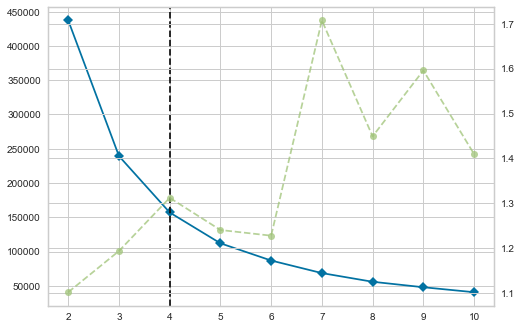

In [10]:
final_df_2020, initial_centroids = clustering(final_df_2020, '2020',[])

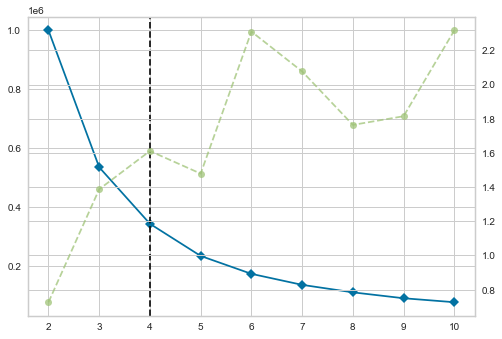

In [11]:
final_df_2019 = clustering(final_df_2019, '2019', initial_centroids)

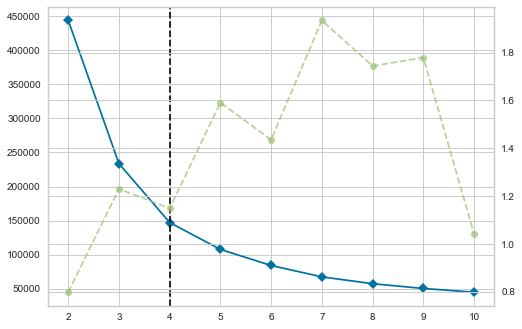

In [12]:
final_df_2018 = clustering(final_df_2018, '2018', initial_centroids)

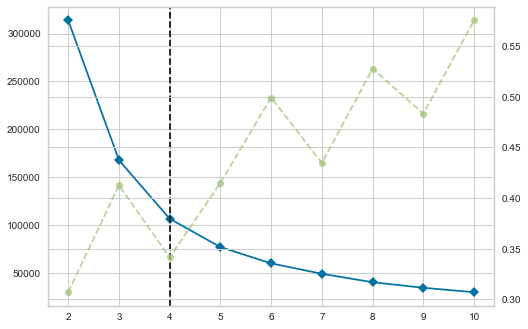

In [13]:
final_df_2017 = clustering(final_df_2017, '2017', initial_centroids)

In [14]:
def plot_group_distribution(final_df, year):
    
    pal = ["#98fb98","#ff0000", "#00008B","#FFEB2A", "#CBEDDD"]
    plt.figure(figsize=(7,7))
    pl = sns.countplot(x=final_df['Group' + '_' + year], palette=pal)
    pl.set_title("Distribution Of The Clusters")
    plt.show()

In [15]:
def plot_swarm_box(x, y):
    
    pal = ["#98fb98","#ff0000", "#00008B","#FFEB2A", "#CBEDDD"]
    plt.figure()    
    pl=sns.boxenplot(x=x, y=y, palette=pal)
    plt.show()

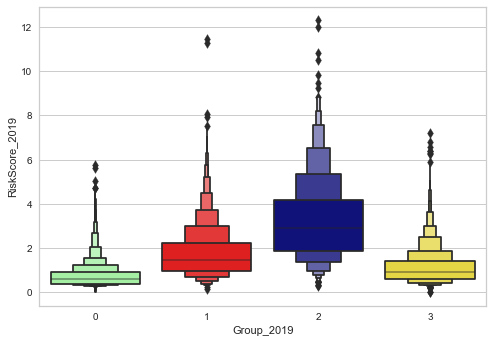

In [16]:
plot_swarm_box(x=final_df_2019['Group_2019'], y=final_df_2019['RiskScore_2019'])

## 3. Model for Prediction

**3.1 Making the cost label**

In [17]:
def compute_expenditure_factor(final_df, year):
    
    """
    Compute the expenditure factor and actual cost label for the dataset
    """
    
    total_expend_of_group = final_df.groupby(['Group'+'_'+year], as_index=False)['Total_Expenditure'+'_'+year].sum()
    num_mem_of_group = final_df.groupby(['Group'+'_'+year], as_index=False)['MemberID'].count()
    num_mem_of_group.columns = ['Group'+'_'+year, 'num_mem_of_group'+'_'+year]
    avg_expend_of_group = total_expend_of_group.copy()
    avg_expend_of_group['num_mem_of_group'+'_'+year] = num_mem_of_group['num_mem_of_group'+'_'+year]
    avg_expend_of_group['avg_exp_per_group'+'_'+year] = avg_expend_of_group['Total_Expenditure'+'_'+year] / avg_expend_of_group['num_mem_of_group'+'_'+year]
    final_df['avg_exp_per_group'+'_'+year] = np.nan
    
    for i in tqdm(range(final_df.shape[0])):
        if final_df.iloc[i]['Group'+'_'+year] == 0:
            final_df.iloc[i, final_df.columns.get_loc('avg_exp_per_group'+'_'+year)] = avg_expend_of_group.loc[avg_expend_of_group['Group'+'_'+year] == 0]['avg_exp_per_group'+'_'+year]
        elif final_df.iloc[i]['Group'+'_'+year] == 1:
            final_df.iloc[i, final_df.columns.get_loc('avg_exp_per_group'+'_'+year)] = avg_expend_of_group.loc[avg_expend_of_group['Group'+'_'+year] == 1]['avg_exp_per_group'+'_'+year]
        elif final_df.iloc[i]['Group'+'_'+year] == 2:
            final_df.iloc[i, final_df.columns.get_loc('avg_exp_per_group'+'_'+year)] = avg_expend_of_group.loc[avg_expend_of_group['Group'+'_'+year] == 2]['avg_exp_per_group'+'_'+year]
        elif final_df.iloc[i]['Group'+'_'+year] == 3:
            final_df.iloc[i, final_df.columns.get_loc('avg_exp_per_group'+'_'+year)] = avg_expend_of_group.loc[avg_expend_of_group['Group'+'_'+year] == 3]['avg_exp_per_group'+'_'+year]
        elif final_df.iloc[i]['Group'+'_'+year] == 4:
            final_df.iloc[i, final_df.columns.get_loc('avg_exp_per_group'+'_'+year)] = avg_expend_of_group.loc[avg_expend_of_group['Group'+'_'+year] == 4]['avg_exp_per_group'+'_'+year]
            
    final_df = final_df.reset_index(drop=True)
    final_df['Expenditure_factor'+'_'+year] = final_df['Total_Expenditure'+'_'+year] / final_df['avg_exp_per_group'+'_'+year]
    final_df['Actual_cost_label'+'_'+year] = final_df['Expenditure_factor'+'_'+year].apply(lambda x: 1 if x>1 else 0)
    
    return final_df

In [18]:
final_df_2020 = compute_expenditure_factor(final_df_2020, '2020')
final_df_2019 = compute_expenditure_factor(final_df_2019, '2019')
final_df_2018 = compute_expenditure_factor(final_df_2018, '2018')
final_df_2017 = compute_expenditure_factor(final_df_2017, '2017')

100%|████████████████████████████████████████████████████████████████████████████| 8827/8827 [00:07<00:00, 1150.82it/s]


**3.2 Features**

In [19]:
def top_list_and_other_list_for_object_column(df, column, num_top_select):
    
    """
    Make the list of most frequent appearance objects
    """
    
    col_counter = Counter(df[column].str.strip().replace({'': np.nan}).dropna())
    col_counter = sorted(col_counter.items(), key=lambda x:x[1], reverse=True)
    col_Top = list(col_counter[:num_top_select])
    col_TopList = []
    
    for element in col_Top:
        col_TopList.append(element[0])
    
    col_OtherList = set(df[column].str.strip().replace({'': np.nan}).dropna().unique()) - set(col_TopList)
    
    return col_TopList, col_OtherList, col_counter

In [20]:
def top_list_and_other_list_for_number_column(df, column, num_top_select):
    
    """
    Make the list of most frequent appearance numbers
    """
    
    col_counter = Counter(df[column].dropna())
    col_counter = sorted(col_counter.items(), key=lambda x:x[1], reverse=True)
    col_Top = list(col_counter[:num_top_select])
    col_TopList = []
    
    for element in col_Top:
        col_TopList.append(str(element[0]))
    
    temp = df[column].dropna().unique()
    full_list = []
    
    for item in temp:
        full_list.append(str(item))
        
    col_OtherList = set(full_list) - set(col_TopList)
    
    return col_TopList, col_OtherList, col_counter

In [21]:
def encoding_column(df, column, top_list, other_list):
    
    """
    Encode the object to number
    """
    
    df[column] = df[column].astype(str)
    df[column] = df[column].apply(lambda x: x.replace(' ','').split(','))

    for code in top_list:  
        df[column + '_' + str(code)] = df[column].apply(lambda x: 1 if code in x else 0)
    
    df[column + '_other'] = np.nan
    df[column + '_other'] = df[column].apply(lambda x: 1 if any(item in x for item in other_list) else 0)
    
    return df

In [22]:
def check_correct_or_not(df, column, idx, num_last_columns):    
    return df.iloc[idx][column], df.iloc[idx, -num_last_columns:]

In [23]:
def make_encoding_features(final_df, CLMS, column, num_code, year, corr_thresh):
    
    """
    Encode the objects which have highest correlation with expenditure factor to number
    """
    
    col_TopList, col_OtherList, col_counter = top_list_and_other_list_for_object_column(CLMS, column, num_code)
    temp = final_df[[column+'_'+year, 'Expenditure_factor'+'_'+str(int(year)+1)]]
    temp = encoding_column(temp, column+'_'+year, col_TopList, col_OtherList)
    temp = temp.drop([column+'_'+year, column+'_'+year+'_other'], axis=1)    
    corr = temp.corr()
    corr = corr.reset_index(drop=False)
    corr = corr.iloc[1:][['index', 'Expenditure_factor'+'_'+str(int(year)+1)]]
    corr = corr.reset_index(drop=True)
    corr.columns = [column, 'Corr_with_Expenditure_factor']
    corr = corr.sort_values('Corr_with_Expenditure_factor', ascending=False)
    corr['1_Count'] = np.nan

    for i in range(corr.shape[0]):
        corr.iloc[i, corr.columns.get_loc('1_Count')] = Counter(temp[corr.iloc[i][column]])[1]
        
    code_list = corr[corr['Corr_with_Expenditure_factor']>corr_thresh][column]
    
    for code in code_list:
        final_df[code] = temp[code]
        final_df[code] = final_df[code].fillna(999)
        
    return final_df, corr

In [24]:
def making_HCC_features(final_df, year):
    
    """
    Make top HCC features that have highest correlation with expenditure facture
    """
    
    all_HCC = pd.read_csv('all HCC new.csv')
    all_HCC['DGNS_CDS'] = all_HCC['DGNS_CDS'].str.split(',')
    HCCCode_list = all_HCC['HCCCode']
    
    member_HCC = pd.read_csv('HCC'+'_'+year+'.csv')
    
    temp1 = member_HCC.copy()

    for hcc_code in tqdm(HCCCode_list):
        temp1[hcc_code] = member_HCC['HCCCodes'].apply(lambda x: 1 if hcc_code in x else 0)
        
    temp = final_df[['MemberID', 'Expenditure_factor'+'_'+str(int(year)+1)]]
    temp = temp.merge(temp1, how='left', left_on='MemberID', right_on='MEMBERID')
    temp = temp.drop(['MemberID', 'MEMBERID', 'HCCCodes'], axis=1)
    
    corr = temp.corr()
    corr = corr.reset_index(drop=False)
    corr = corr.iloc[1:][['index', 'Expenditure_factor'+'_'+str(int(year)+1)]]
    corr = corr.reset_index(drop=True)
    corr.columns = ['HCC', 'Corr_with_Expenditure_factor']
    corr = corr.sort_values('Corr_with_Expenditure_factor', ascending=False)
    corr['1_Count'] = np.nan

    for i in range(corr.shape[0]):
        corr.iloc[i, corr.columns.get_loc('1_Count')] = Counter(temp[corr.iloc[i]['HCC']])[1]
        
    top_HCC_list = corr.dropna().iloc[:5]['HCC']
    bottom_HCC_list = corr.dropna().iloc[-5:]['HCC']

    for HCC in top_HCC_list:
        final_df[HCC] = temp[HCC]
        final_df[HCC] = final_df[HCC].fillna(999)

    for HCC in bottom_HCC_list:
        final_df[HCC] = temp[HCC]
        final_df[HCC] = final_df[HCC].fillna(999)
        
    return final_df, corr, top_HCC_list, bottom_HCC_list

In [25]:
def making_Hedis_features(final_df, year):
    
    """
    Make top Hedis features that have highest correlation with expenditure facture
    """
    
    Hedis_gap_member = pd.read_csv('Hedis'+'_'+year+'.csv')
    Hedis_gap_map = {'Y': 1, 'N': 0}
    columns_list = Hedis_gap_member.iloc[:, -46:].columns

    for col in columns_list:
        Hedis_gap_member[col] = Hedis_gap_member[col].map(Hedis_gap_map)
        
    Hedis_gap_member[columns_list] = Hedis_gap_member[columns_list].fillna(999)
    
    temp = final_df[['MemberID', 'Expenditure_factor'+'_'+str(int(year)+1)]]
    temp1 = Hedis_gap_member[columns_list]
    temp1['MemberID'] = Hedis_gap_member['MemberID']    
    temp = temp.merge(temp1, how='left', left_on='MemberID', right_on='MemberID')
    
    corr = temp.drop(['MemberID'], axis=1).corr()
    corr = corr.reset_index(drop=False)
    corr = corr.iloc[1:][['index', 'Expenditure_factor'+'_'+str(int(year)+1)]]
    corr = corr.reset_index(drop=True)
    corr.columns = ['Hedis_code', 'Corr_with_Expenditure_factor']
    corr = corr.sort_values('Corr_with_Expenditure_factor', ascending=False)
    corr['1_Count'] = np.nan

    for i in range(corr.shape[0]):
        corr.iloc[i, corr.columns.get_loc('1_Count')] = Counter(temp[corr.iloc[i]['Hedis_code']])[1]
        
    top_Hedis_code_list = corr.dropna().iloc[:5]['Hedis_code']
    bottom_Hedis_code_list = corr.dropna().iloc[-5:]['Hedis_code']

    for code in top_Hedis_code_list:
        final_df = final_df.merge(temp[['MemberID' ,code]], how='left', left_on='MemberID', right_on='MemberID')
        final_df[code] = final_df[code].fillna(999)
        final_df = final_df.rename(columns={code: 'Hedis_'+code})

    for code in bottom_Hedis_code_list:
        final_df = final_df.merge(temp[['MemberID' ,code]], how='left', left_on='MemberID', right_on='MemberID')
        final_df[code] = final_df[code].fillna(999)
        final_df = final_df.rename(columns={code: 'Hedis_'+code})
        
    return final_df, corr, top_Hedis_code_list, bottom_Hedis_code_list

In [26]:
final_df_for_train = pd.merge(final_df_2020[['MemberID', 'Expenditure_factor_2020','Actual_cost_label_2020']], final_df_2019, how='left', left_on='MemberID', right_on='MemberID')

In [27]:
final_df_for_train, _ = make_encoding_features(final_df_for_train, CLMS_2019, 'AdmissionSourceCode', 9, '2019', 0.1)
final_df_for_train, _ = make_encoding_features(final_df_for_train, CLMS_2019, 'ClaimTypeCode', 10, '2019', 0.1)
final_df_for_train, _ = make_encoding_features(final_df_for_train, CLMS_2019, 'TypeOfServiceCode', 31, '2019', 0.1)
CLMS_2019['PatientDischargeStatus'] = CLMS_2019['PatientDischargeStatus'].astype(str)
final_df_for_train, _ = make_encoding_features(final_df_for_train, CLMS_2019, 'PatientDischargeStatus', 33, '2019', 0.1)
final_df_for_train, corr, top_HCC_list, bottom_HCC_list = making_HCC_features(final_df_for_train, '2019')
final_df_for_train, corr, top_Hedis_code_list, bottom_Hedis_code_list = making_Hedis_features(final_df_for_train, '2019')

100%|█████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 134.48it/s]


-------------

**3.3 Bulding Model**

In [28]:
drop_columns = ['DiagnosisCode', 'NDC', 'DaysSupply', 'AvoidableERIND', 'AdmissionSourceCode',
               'MemberMedicareStatusCD', 'MemberDualStatusCD', 'ClaimTypeCode', 'TypeOfServiceCode', 'PatientDischargeStatus',
               'Actual_cost_label', 'avg_exp_per_group', 'Group']

for i in range(len(drop_columns)):
    drop_columns[i] = drop_columns[i] + '_' + '2019'
    
final_df_for_train = final_df_for_train.drop(drop_columns, axis=1)
final_df_for_train = final_df_for_train.drop(['Expenditure_factor_2020'], axis=1)

In [29]:
old_name_columns = final_df_for_train.columns
new_name_columns = []

for i in range(len(old_name_columns)):
    temp = old_name_columns[i]
    temp = temp.replace('2019','last_year')
    new_name_columns.append(temp)
    
final_df_for_train.columns = new_name_columns

In [30]:
final_df_for_train = final_df_for_train.merge(final_df_2018[['MemberID', 'Total_Expenditure_2018', 'Expenditure_factor_2018']], how='left', left_on='MemberID', right_on='MemberID')
final_df_for_train = final_df_for_train.merge(final_df_2017[['MemberID', 'Total_Expenditure_2017', 'Expenditure_factor_2017']], how='left', left_on='MemberID', right_on='MemberID')

In [31]:
final_df_for_train = final_df_for_train.rename(columns={'Total_Expenditure_2018':'Total_Expenditure_last_2years',
                                                       'Expenditure_factor_2018':'Expenditure_factor_last_2years',
                                                       'Total_Expenditure_2017':'Total_Expenditure_last_3years',
                                                       'Expenditure_factor_2017':'Expenditure_factor_last_3years'})

In [32]:
final_df_for_train.shape

(12363, 42)

In [33]:
fill_with_0 = ['Total_Expenditure_last_year', 'DiagnosisCount_last_year', 'NDCCount_last_year', 'LOS_last_year',
              'ReadmissionCount_last_year', 'AdmissionCount_last_year', 'ERCount_last_year', 'NDCQuantity_last_year',
              'RiskScore_last_year', 'MedicalClaimsCount_last_year', 'RXClaimsCount_last_year', 'Expenditure_factor_last_year',
              'Total_Expenditure_last_2years', 'Expenditure_factor_last_2years', 'Total_Expenditure_last_3years',
              'Expenditure_factor_last_3years']
fill_with_999 = list(set(final_df_for_train.columns) - set(fill_with_0))
final_df_for_train[fill_with_0] = final_df_for_train[fill_with_0].fillna(0)
final_df_for_train[fill_with_999] = final_df_for_train[fill_with_999].fillna(999)

In [34]:
final_df_for_train['Total_Expenditure_last_year'] = final_df_for_train['Total_Expenditure_last_year'].apply(lambda x: 0 if x<0 else x)
final_df_for_train['Expenditure_factor_last_year'] = final_df_for_train['Expenditure_factor_last_year'].apply(lambda x: 0 if x<0 else x)
final_df_for_train['Total_Expenditure_last_2years'] = final_df_for_train['Total_Expenditure_last_2years'].apply(lambda x: 0 if x<0 else x)
final_df_for_train['Expenditure_factor_last_2years'] = final_df_for_train['Expenditure_factor_last_2years'].apply(lambda x: 0 if x<0 else x)
final_df_for_train['Total_Expenditure_last_3years'] = final_df_for_train['Total_Expenditure_last_3years'].apply(lambda x: 0 if x<0 else x)
final_df_for_train['Expenditure_factor_last_3years'] = final_df_for_train['Expenditure_factor_last_3years'].apply(lambda x: 0 if x<0 else x)

In [35]:
corr = final_df_for_train.drop(['MemberID'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,Actual_cost_label_2020,Total_Expenditure_last_year,DiagnosisCount_last_year,NDCCount_last_year,LOS_last_year,ReadmissionCount_last_year,AdmissionCount_last_year,ERCount_last_year,NDCQuantity_last_year,YOB_last_year,MemberZipCode_last_year,MemberGender_last_year,RaceCode_last_year,RiskScore_last_year,MedicalClaimsCount_last_year,RXClaimsCount_last_year,Expenditure_factor_last_year,HCC124,HCC47,HCC77,HCC71,HCC8,HCC10,HCC138,HCC59,HCC108,HCC19,Hedis_BCS,Hedis_COL,Hedis_DAE2,Hedis_DAE1,Hedis_ABA,Hedis_AMM,Hedis_MAH,Hedis_MAD,Hedis_ART,Hedis_PCR,Total_Expenditure_last_2years,Expenditure_factor_last_2years,Total_Expenditure_last_3years,Expenditure_factor_last_3years
Actual_cost_label_2020,1.000000,0.156810,0.074634,0.102238,0.125138,0.050637,0.108795,0.053410,0.059147,0.025673,0.003362,-0.027321,-0.027473,0.222675,0.126261,0.106013,0.153578,-0.094604,-0.094613,-0.094615,-0.094617,-0.094571,-0.094606,-0.094624,-0.094622,-0.094621,-0.094646,0.066764,0.056080,0.011156,0.011151,0.034916,-0.041287,-0.066907,-0.086886,-0.023334,-0.072363,0.098329,0.092924,0.067536,0.067870
Total_Expenditure_last_year,0.156810,1.000000,0.606995,0.248890,0.578025,0.332478,0.700396,0.218153,0.092366,0.072010,0.049512,-0.073821,-0.073847,0.498545,0.702278,0.195651,0.436507,-0.198198,-0.198155,-0.198197,-0.198192,-0.198004,-0.198058,-0.198207,-0.198176,-0.198141,-0.198220,0.063652,0.106517,-0.020726,-0.020750,0.030796,-0.119281,-0.053584,-0.077821,-0.040556,-0.452708,0.246125,0.119411,0.154907,0.073684
DiagnosisCount_last_year,0.074634,0.606995,1.000000,0.413465,0.461972,0.238586,0.518671,0.383768,0.162297,0.226349,0.127073,-0.231595,-0.232052,0.576418,0.876927,0.334508,0.089626,-0.366413,-0.366380,-0.366414,-0.366411,-0.366236,-0.366226,-0.366412,-0.366359,-0.366310,-0.366455,0.014449,0.116829,-0.120426,-0.120458,0.041424,-0.163874,-0.088106,-0.088106,-0.078551,-0.440461,0.226724,0.054542,0.184356,0.019114
NDCCount_last_year,0.102238,0.248890,0.413465,1.000000,0.190847,0.074284,0.189078,0.208512,0.484208,0.151567,0.079017,-0.148525,-0.148298,0.325969,0.403771,0.892262,0.085289,-0.264986,-0.264979,-0.264982,-0.264982,-0.264900,-0.264912,-0.264983,-0.264902,-0.264947,-0.265009,0.036612,0.074031,0.044610,0.044549,-0.003314,-0.254126,-0.487167,-0.355400,-0.049126,-0.204966,0.147599,0.059532,0.130240,0.053579
LOS_last_year,0.125138,0.578025,0.461972,0.190847,1.000000,0.235017,0.501787,0.202333,0.085027,0.050463,0.034438,-0.054026,-0.054145,0.427901,0.511461,0.176917,0.232194,-0.154982,-0.154952,-0.154973,-0.154968,-0.154836,-0.154835,-0.154984,-0.154957,-0.154919,-0.155005,0.063033,0.122737,-0.001072,-0.001092,0.068875,-0.105751,-0.020650,-0.040716,-0.009428,-0.367022,0.251058,0.083314,0.119168,0.051474
ReadmissionCount_last_year,0.050637,0.332478,0.238586,0.074284,0.235017,1.000000,0.564210,0.115449,0.012131,0.014934,0.004098,-0.014751,-0.014740,0.221099,0.269384,0.054068,0.080135,-0.054213,-0.054192,-0.054213,-0.054213,-0.054116,-0.054151,-0.054219,-0.054202,-0.054196,-0.054225,0.042523,0.069174,0.014813,0.014804,0.017318,-0.028103,-0.019988,-0.011078,0.002008,-0.214296,0.083586,0.034825,0.052277,0.019818
AdmissionCount_last_year,0.108795,0.700396,0.518671,0.189078,0.501787,0.564210,1.000000,0.231930,0.056344,0.046314,0.031362,-0.047573,-0.047555,0.441518,0.553839,0.143686,0.235842,-0.159261,-0.159227,-0.159256,-0.159250,-0.159063,-0.159120,-0.159266,-0.159239,-0.159207,-0.159282,0.070530,0.117093,-0.002924,-0.002947,0.036310,-0.118362,-0.034291,-0.040302,0.005920,-0.608592,0.137791,0.052348,0.099376,0.027887
ERCount_last_year,0.053410,0.218153,0.383768,0.208512,0.202333,0.115449,0.231930,1.000000,0.058403,0.061379,0.026738,-0.057190,-0.057283,0.229475,0.355523,0.171892,0.025121,-0.132230,-0.132221,-0.132228,-0.132229,-0.132160,-0.132149,-0.132235,-0.132194,-0.132180,-0.132245,0.023874,0.073922,0.075296,0.075277,-0.002153,-0.113203,-0.015571,-0.044768,-0.007957,-0.214245,0.099144,0.031553,0.088346,0.018427
NDCQuantity_last_year,0.059147,0.092366,0.162297,0.4842

In [36]:
scores, pvalues = chi2(final_df_for_train.drop(['MemberID','Actual_cost_label_2020'], axis=1), final_df_for_train['Actual_cost_label_2020'])
pvalues=["{0:.7f}".format(x)for x in pvalues]
chi2_distribution_df = pd.DataFrame({'Features':final_df_for_train.drop(['MemberID','Actual_cost_label_2020'], axis=1).columns,'Chi2_score':scores, 'P_values':pvalues})
chi2_distribution_df = chi2_distribution_df.sort_values('Chi2_score', ascending=False)

In [37]:
pd.set_option('display.max_rows', chi2_distribution_df.shape[0]+1)

In [38]:
chi2_distribution_df

,Features,Chi2_score,P_values
0,Total_Expenditure_last_year,14399935.253,0.0000000
36,Total_Expenditure_last_2years,4795928.817,0.0000000
38,Total_Expenditure_last_3years,2179325.295,0.0000000
25,HCC19,77468.467,0.0000000
19,HCC71,77466.335,0.0000000
18,HCC77,77461.734,0.0000000
22,HCC138,77459.423,0.0000000
17,HCC47,77452.850,0.0000000
23,HCC59,77440.281,0.0000000
16,HCC124,77439.309,0.0000000


In [39]:
pd.reset_option('max_rows')

In [40]:
feature_used = chi2_distribution_df[chi2_distribution_df['Chi2_score']>50]['Features']

In [41]:
X = final_df_for_train[feature_used]
y = final_df_for_train['Actual_cost_label_2020']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=111, stratify=y_train)

In [42]:
type_count = Counter(final_df_for_train['Actual_cost_label_2020'])

In [43]:
class_weights = len(final_df_for_train['Actual_cost_label_2020'])/pd.DataFrame(type_count.values())/len(type_count)
classes = list(type_count.keys())
class_weights_map = {}

for cls, weight in zip(type_count.keys(), class_weights[0]):
    class_weights_map[cls] = weight

In [44]:
class_weights_map

{0: 0.673732970027248, 1: 1.9389899623588456}

In [45]:
class_weights_map = dict({0: 0.67, 1:1.95})

In [46]:
def multi_weighted_logloss(y_true, y_preds, classes, class_weights_map):
    
    """
    custom loss function
    """
    
    y_p = y_preds.reshape(y_true.shape[0], 1, order='F')
    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_log_ones = np.sum(y_ohe.values * np.log(y_p), axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weights_map[k] for k in range(len(classes))])
    y_w = y_log_ones * class_arr / nb_pos
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

def lgbm_multi_weighted_logloss(y_true, y_preds):
    loss = multi_weighted_logloss(y_true, y_preds, classes, class_weights_map)
    return 'wloss', loss, False

In [47]:
# params = {'max_depth':2,
#          'learning_rate':0.05,
#          'num_leaves':2,
#          'reg_alpha':2,
#          'reg_lambda':1,
#          'colsample_bytree':0.5,
#          'random_state':18,
#          'subsample' :0.5,
#          'n_estimators':500
#         }

params = {'max_depth':2,
         'learning_rate':0.0009,
         'num_leaves':6,
         'reg_alpha':0,
         'reg_lambda':0,
         'colsample_bytree':0.5,
         'random_state':111,
         'subsample' :1,
         'n_estimators':1000
        }

In [48]:
clf = LGBMClassifier(**params)
clf.fit(X_train, y_train, eval_set=[(X_train,y_train), (X_valid,y_valid)], eval_metric=lgbm_multi_weighted_logloss,
       verbose=2, early_stopping_rounds=100, sample_weight = y_train.map(class_weights_map))

[2]	training's binary_logloss: 0.692987	training's wloss: 0.687562	valid_1's binary_logloss: 0.695709	valid_1's wloss: 0.687586
[4]	training's binary_logloss: 0.69285	training's wloss: 0.687497	valid_1's binary_logloss: 0.695583	valid_1's wloss: 0.687547
[6]	training's binary_logloss: 0.692706	training's wloss: 0.687427	valid_1's binary_logloss: 0.695451	valid_1's wloss: 0.687501
[8]	training's binary_logloss: 0.692583	training's wloss: 0.687369	valid_1's binary_logloss: 0.695334	valid_1's wloss: 0.687462
[10]	training's binary_logloss: 0.69247	training's wloss: 0.687315	valid_1's binary_logloss: 0.695219	valid_1's wloss: 0.687419
[12]	training's binary_logloss: 0.692342	training's wloss: 0.687254	valid_1's binary_logloss: 0.695095	valid_1's wloss: 0.68738
[14]	training's binary_logloss: 0.692199	training's wloss: 0.687186	valid_1's binary_logloss: 0.694965	valid_1's wloss: 0.687336
[16]	training's binary_logloss: 0.692065	training's wloss: 0.687123	valid_1's binary_logloss: 0.694835	v

[136]	training's binary_logloss: 0.685222	training's wloss: 0.684002	valid_1's binary_logloss: 0.688622	valid_1's wloss: 0.685532
[138]	training's binary_logloss: 0.685111	training's wloss: 0.683954	valid_1's binary_logloss: 0.688514	valid_1's wloss: 0.685503
[140]	training's binary_logloss: 0.685007	training's wloss: 0.683908	valid_1's binary_logloss: 0.688411	valid_1's wloss: 0.68548
[142]	training's binary_logloss: 0.684902	training's wloss: 0.683863	valid_1's binary_logloss: 0.688314	valid_1's wloss: 0.685449
[144]	training's binary_logloss: 0.684821	training's wloss: 0.683827	valid_1's binary_logloss: 0.688241	valid_1's wloss: 0.685427
[146]	training's binary_logloss: 0.684711	training's wloss: 0.683779	valid_1's binary_logloss: 0.688134	valid_1's wloss: 0.685399
[148]	training's binary_logloss: 0.684623	training's wloss: 0.683741	valid_1's binary_logloss: 0.688057	valid_1's wloss: 0.685385
[150]	training's binary_logloss: 0.684519	training's wloss: 0.683696	valid_1's binary_loglo

[272]	training's binary_logloss: 0.678529	training's wloss: 0.6812	valid_1's binary_logloss: 0.682523	valid_1's wloss: 0.684149
[274]	training's binary_logloss: 0.678434	training's wloss: 0.681163	valid_1's binary_logloss: 0.682438	valid_1's wloss: 0.684131
[276]	training's binary_logloss: 0.678349	training's wloss: 0.681129	valid_1's binary_logloss: 0.682354	valid_1's wloss: 0.68411
[278]	training's binary_logloss: 0.67828	training's wloss: 0.681102	valid_1's binary_logloss: 0.682284	valid_1's wloss: 0.684088
[280]	training's binary_logloss: 0.678186	training's wloss: 0.681065	valid_1's binary_logloss: 0.6822	valid_1's wloss: 0.684072
[282]	training's binary_logloss: 0.678085	training's wloss: 0.681026	valid_1's binary_logloss: 0.682107	valid_1's wloss: 0.684051
[284]	training's binary_logloss: 0.677993	training's wloss: 0.68099	valid_1's binary_logloss: 0.682021	valid_1's wloss: 0.684032
[286]	training's binary_logloss: 0.677887	training's wloss: 0.680949	valid_1's binary_logloss: 0.

[404]	training's binary_logloss: 0.672791	training's wloss: 0.679044	valid_1's binary_logloss: 0.677307	valid_1's wloss: 0.683275
[406]	training's binary_logloss: 0.672712	training's wloss: 0.679016	valid_1's binary_logloss: 0.677233	valid_1's wloss: 0.683267
[408]	training's binary_logloss: 0.672624	training's wloss: 0.678986	valid_1's binary_logloss: 0.677147	valid_1's wloss: 0.683251
[410]	training's binary_logloss: 0.672563	training's wloss: 0.678964	valid_1's binary_logloss: 0.677088	valid_1's wloss: 0.68325
[412]	training's binary_logloss: 0.67248	training's wloss: 0.678935	valid_1's binary_logloss: 0.677016	valid_1's wloss: 0.683244
[414]	training's binary_logloss: 0.672412	training's wloss: 0.678911	valid_1's binary_logloss: 0.676945	valid_1's wloss: 0.683233
[416]	training's binary_logloss: 0.672334	training's wloss: 0.678884	valid_1's binary_logloss: 0.676872	valid_1's wloss: 0.683225
[418]	training's binary_logloss: 0.672266	training's wloss: 0.67886	valid_1's binary_logloss

[538]	training's binary_logloss: 0.667789	training's wloss: 0.677378	valid_1's binary_logloss: 0.672766	valid_1's wloss: 0.682865
[540]	training's binary_logloss: 0.667707	training's wloss: 0.677353	valid_1's binary_logloss: 0.672691	valid_1's wloss: 0.682858
[542]	training's binary_logloss: 0.66762	training's wloss: 0.677326	valid_1's binary_logloss: 0.672619	valid_1's wloss: 0.682853
[544]	training's binary_logloss: 0.667564	training's wloss: 0.677308	valid_1's binary_logloss: 0.672567	valid_1's wloss: 0.682845
[546]	training's binary_logloss: 0.667506	training's wloss: 0.677289	valid_1's binary_logloss: 0.672519	valid_1's wloss: 0.682851
[548]	training's binary_logloss: 0.667437	training's wloss: 0.677268	valid_1's binary_logloss: 0.67246	valid_1's wloss: 0.682849
[550]	training's binary_logloss: 0.667365	training's wloss: 0.677246	valid_1's binary_logloss: 0.672394	valid_1's wloss: 0.682845
[552]	training's binary_logloss: 0.667284	training's wloss: 0.677222	valid_1's binary_loglos

[668]	training's binary_logloss: 0.663328	training's wloss: 0.676086	valid_1's binary_logloss: 0.66882	valid_1's wloss: 0.682743
[670]	training's binary_logloss: 0.663281	training's wloss: 0.676071	valid_1's binary_logloss: 0.668783	valid_1's wloss: 0.682741
[672]	training's binary_logloss: 0.663225	training's wloss: 0.676056	valid_1's binary_logloss: 0.668731	valid_1's wloss: 0.682739
[674]	training's binary_logloss: 0.663169	training's wloss: 0.676042	valid_1's binary_logloss: 0.668679	valid_1's wloss: 0.682738
[676]	training's binary_logloss: 0.663108	training's wloss: 0.676025	valid_1's binary_logloss: 0.668623	valid_1's wloss: 0.682741
[678]	training's binary_logloss: 0.663046	training's wloss: 0.676007	valid_1's binary_logloss: 0.668566	valid_1's wloss: 0.682749
[680]	training's binary_logloss: 0.662991	training's wloss: 0.675993	valid_1's binary_logloss: 0.668514	valid_1's wloss: 0.682747
[682]	training's binary_logloss: 0.662937	training's wloss: 0.675977	valid_1's binary_loglo

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.0009, max_depth=2,
               n_estimators=1000, num_leaves=6, random_state=111, reg_alpha=0,
               reg_lambda=0, subsample=1)

In [49]:
val_predictions = clf.predict(X_valid)
test_predictions = clf.predict(X_test)

In [50]:
print('Multi_weight_log_loss of validation set:', lgbm_multi_weighted_logloss(y_valid, val_predictions))
print('Multi_weight_log_loss of test set:', lgbm_multi_weighted_logloss(y_test, test_predictions))

Multi_weight_log_loss of validation set: ('wloss', 16.149563216097324, False)
Multi_weight_log_loss of test set: ('wloss', 16.135854940216365, False)


In [51]:
compare = pd.DataFrame({'predict': test_predictions, 'True_value': y_test})
confusion_matrix = pd.crosstab(compare['True_value'], compare['predict'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,1201,634
1,257,381


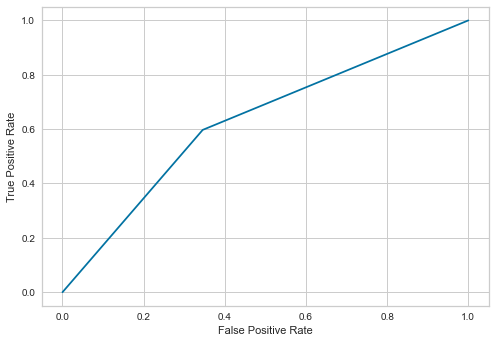

In [52]:
fpr, tpr, _ = metrics.roc_curve(compare['True_value'], compare['predict'])

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [53]:
f1_score(test_predictions, y_test)

0.4609800362976406

In [54]:
feature_names = X_train.columns
# fe_imp_score = sorted(zip(clf.feature_importances_, feature_names), reverse=True)
fe_imp_score = sorted(zip(clf.booster_.feature_importance(importance_type='gain'), feature_names), reverse=True)

In [55]:
fe_imp_score

[(134310.54408454895, 'Expenditure_factor_last_year'),
 (67691.37459182739, 'RiskScore_last_year'),
 (28140.578073501587, 'Total_Expenditure_last_year'),
 (13185.076860427856, 'RXClaimsCount_last_year'),
 (3756.0510082244873, 'DiagnosisCount_last_year'),
 (3428.557497024536, 'Expenditure_factor_last_2years'),
 (3101.130584716797, 'NDCQuantity_last_year'),
 (2982.38191986084, 'NDCCount_last_year'),
 (2878.025909423828, 'LOS_last_year'),
 (2795.172986984253, 'Expenditure_factor_last_3years'),
 (363.95880126953125, 'Total_Expenditure_last_2years'),
 (259.23669815063477, 'MedicalClaimsCount_last_year'),
 (186.0044994354248, 'HCC19'),
 (137.6666965484619, 'RaceCode_last_year'),
 (117.77329635620117, 'Hedis_MAD'),
 (106.67070198059082, 'AdmissionCount_last_year'),
 (38.17430114746094, 'MemberZipCode_last_year'),
 (31.841899871826172, 'Hedis_COL'),
 (23.16080093383789, 'Hedis_DAE2'),
 (0.0, 'YOB_last_year'),
 (0.0, 'Total_Expenditure_last_3years'),
 (0.0, 'ReadmissionCount_last_year'),
 (0.0,

In [56]:
fe_imp_df = pd.DataFrame({'model_result': fe_imp_score})
fe_imp_df['score'] = fe_imp_df['model_result'].apply(lambda x: x[0])
fe_imp_df['feature'] = fe_imp_df['model_result'].apply(lambda x: x[1])
fe_imp_df['contribution'] = fe_imp_df['score'].apply(lambda x: x*100/sum(fe_imp_df['score']))
important_feature_list = fe_imp_df.loc[fe_imp_df['contribution']>0]['feature'].values.tolist()

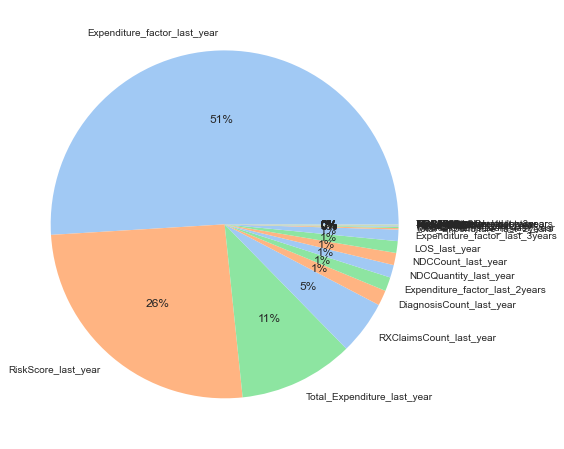

In [57]:
# for pie chart
data = fe_imp_df['contribution']
labels = fe_imp_df['feature']
colors = sns.color_palette('pastel')[0:3]
plt.figure(1 , figsize = (8 , 8))
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

**Logistic Regression Model (Linear Model)**

In [58]:
LR_model = LogisticRegression(penalty='none', dual=False, tol=0.0001, C=0.01, fit_intercept=True, intercept_scaling=1,
                              class_weight=class_weights_map, random_state=111, solver='lbfgs', max_iter=100, multi_class='auto',
                              verbose=10, warm_start=False, n_jobs=None, l1_ratio=None)

In [59]:
LR_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(C=0.01, class_weight={0: 0.67, 1: 1.95}, penalty='none',
                   random_state=111, verbose=10)

In [60]:
val_predictions_LR = LR_model.predict(X_valid)
test_predictions_LR = LR_model.predict(X_test)

In [61]:
f1_score(val_predictions_LR, y_valid), f1_score(test_predictions_LR, y_test)

(0.4050420168067227, 0.41611624834874505)

In [62]:
compare_LR = pd.DataFrame({'predict': test_predictions_LR, 'True_value': y_test})
confusion_matrix_LR = pd.crosstab(compare_LR['True_value'], compare_LR['predict'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_LR

Predicted,0,1
Actual,,
0,1274,561
1,323,315


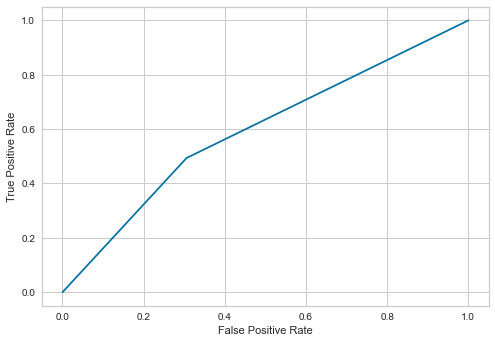

In [63]:
fpr, tpr, _ = metrics.roc_curve(compare_LR['True_value'], compare_LR['predict'])

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [64]:
LR_coef = ["{0:.10f}".format(x)for x in LR_model.coef_[0]]
LR_contribution = pd.DataFrame({'Features':X_train.columns, 'Coef': LR_coef})

In [65]:
pd.options.display.float_format = '{:.10f}'.format

In [66]:
LR_contribution['Coef'] = LR_contribution['Coef'].astype(float)

In [67]:
LR_contribution['abs_value'] = LR_contribution['Coef'].apply(lambda x: abs(x))

In [68]:
LR_contribution['Contribution(%)'] = LR_contribution['abs_value'].apply(lambda x: x/sum(LR_contribution['abs_value'])*100)

In [69]:
LR_contribution = LR_contribution.drop(['abs_value'], axis=1).sort_values('Contribution(%)', ascending=False)

In [70]:
pd.set_option('display.max_rows', LR_contribution.shape[0]+1)

In [71]:
LR_contribution

,Features,Coef,Contribution(%)
20,Hedis_MAD,-0.0004032188,14.1221844726
36,YOB_last_year,0.0003610926,12.6467721964
29,Hedis_AMM,-0.0002091262,7.3243578287
16,Hedis_MAH,-0.0001895211,6.6377161374
22,NDCQuantity_last_year,0.0001614977,5.6562350548
37,Hedis_ART,-0.0001567430,5.4897082199
15,Hedis_BCS,0.0001514705,5.3050461515
24,RXClaimsCount_last_year,0.0001243088,4.3537449275
17,Hedis_ABA,0.0001062615,3.7216630408
21,MedicalClaimsCount_last_year,-0.0000917018,3.2117295525


In [72]:
pd.reset_option('max_rows')

## 4. Predict for 2021

In [73]:
all_HCC = pd.read_csv('all HCC new.csv')
HCCCode_list = all_HCC['HCCCode']
member_HCC_2020 = pd.read_csv('HCC_2020.csv')
member_HCC_2020['HCCCodes'] = member_HCC_2020['HCCCodes'].str.split(',')
temp1 = member_HCC_2020.copy()

for hcc_code in tqdm(HCCCode_list):
    temp1[hcc_code] = member_HCC_2020['HCCCodes'].apply(lambda x: 1 if hcc_code in x else 0)

temp = final_df_2020[['MemberID', 'DiagnosisCode_2020']]
temp = temp.merge(temp1, how='left', left_on='MemberID', right_on='MEMBERID')
temp = temp.drop(['MemberID', 'MEMBERID', 'HCCCodes', 'DiagnosisCode_2020'], axis=1)

for HCC in top_HCC_list:
    final_df_2020[HCC] = temp[HCC]
    final_df_2020[HCC] = final_df_2020[HCC].fillna(999)
    
for HCC in bottom_HCC_list:
    final_df_2020[HCC] = temp[HCC]
    final_df_2020[HCC] = final_df_2020[HCC].fillna(999)

100%|█████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 137.12it/s]


In [74]:
Hedis_gap_member_2020 = pd.read_csv('Hedis_2020.csv')
Hedis_gap_map = {'Y': 1, 'N': 0}

columns_list = Hedis_gap_member_2020.iloc[:, -46:].columns

for col in columns_list:
    Hedis_gap_member_2020[col] = Hedis_gap_member_2020[col].map(Hedis_gap_map)
    
Hedis_gap_member_2020[columns_list] = Hedis_gap_member_2020[columns_list].fillna(999)


columns_list = Hedis_gap_member_2020.iloc[:, -46:].columns
temp = final_df_2020[['MemberID', 'DiagnosisCode_2020']]
temp1 = Hedis_gap_member_2020[columns_list]
temp1['MemberID'] = Hedis_gap_member_2020['MemberID']
temp = temp.merge(temp1, how='left', left_on='MemberID', right_on='MemberID')

for code in top_Hedis_code_list:
    final_df_2020 = final_df_2020.merge(temp[['MemberID' ,code]], how='left', left_on='MemberID', right_on='MemberID')
    final_df_2020[code] = final_df_2020[code].fillna(999)
    final_df_2020 = final_df_2020.rename(columns={code: 'Hedis_'+code})
    
for code in bottom_Hedis_code_list:
    final_df_2020 = final_df_2020.merge(temp[['MemberID' ,code]], how='left', left_on='MemberID', right_on='MemberID')
    final_df_2020[code] = final_df_2020[code].fillna(999)
    final_df_2020 = final_df_2020.rename(columns={code: 'Hedis_'+code})

In [75]:
final_df_for_test = final_df_2020.copy()

In [76]:
old_name_columns = final_df_for_test.columns
new_name_columns = []

for i in range(len(old_name_columns)):
    temp = old_name_columns[i]
    temp = temp.replace('2020','last_year')
    new_name_columns.append(temp)
    
final_df_for_test.columns = new_name_columns

In [77]:
final_df_for_test = final_df_for_test.merge(final_df_2019[['MemberID', 'Total_Expenditure_2019', 'Expenditure_factor_2019']], how='left', left_on='MemberID', right_on='MemberID')
final_df_for_test = final_df_for_test.merge(final_df_2018[['MemberID', 'Total_Expenditure_2018', 'Expenditure_factor_2018']], how='left', left_on='MemberID', right_on='MemberID')

In [78]:
final_df_for_test = final_df_for_test.rename(columns={'Total_Expenditure_2019':'Total_Expenditure_last_2years',
                                                       'Expenditure_factor_2019':'Expenditure_factor_last_2years',
                                                       'Total_Expenditure_2018':'Total_Expenditure_last_3years',
                                                       'Expenditure_factor_2018':'Expenditure_factor_last_3years'})

In [79]:
columns = X_train.columns.to_list()
for_prediction_df = final_df_for_test[columns].fillna(0)
lgbm_predict = clf.predict(for_prediction_df)
LR_predict = LR_model.predict(for_prediction_df)
LR_proba = LR_model.predict_proba(for_prediction_df)
LGBM_proba = clf.predict_proba(for_prediction_df)

In [80]:
final_df_for_test.head()

,MemberID,Total_Expenditure_last_year,DiagnosisCode_last_year,DiagnosisCount_last_year,NDC_last_year,NDCCount_last_year,LOS_last_year,ReadmissionCount_last_year,AdmissionCount_last_year,ERCount_last_year,DaysSupply_last_year,NDCQuantity_last_year,AvoidableERIND_last_year,YOB_last_year,MemberZipCode_last_year,AdmissionSourceCode_last_year,MemberGender_last_year,RaceCode_last_year,MemberMedicareStatusCD_last_year,MemberDualStatusCD_last_year,RiskScore_last_year,ClaimTypeCode_last_year,TypeOfServiceCode_last_year,PatientDischargeStatus_last_year,MedicalClaimsCount_last_year,RXClaimsCount_last_year,Group_last_year,avg_exp_per_group_last_year,Expenditure_factor_last_year,Actual_cost_label_last_year,HCC124,HCC47,HCC77,HCC71,HCC8,HCC10,HCC138,HCC59,HCC108,HCC19,Hedis_BCS,Hedis_COL,Hedis_DAE2,Hedis_DAE1,Hedis_ABA,Hedis_AMM,Hedis_MAH,Hedis_MAD,Hedis_ART,Hedis_PCR,Total_Expenditure_last_2years,Expenditure_factor_last_2years,Total_Expenditure_last_3years,Expenditure_factor_last_3years
0,1A01GT1DH35,1603.4800000000,"Z0001,E7801,M7702,L0889,Z96642,D235,C4442",7.0000000000,NaN,0.0000000000,0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1954.0000000000,21842.0000000000,NaN,1,1,10,0.0000000000,0.9400000000,71,"1,5,2,4",NaN,10.0000000000,NaN,0,1880.4492457868,0.8527111293,0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,999.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,999.0000000000,999.0000000000,999.0000000000,999.0000000000,999.0000000000,1409.9800000000,0.7028117469,NaN,NaN
1,1A02NT3KD91,3557.7900000000,"I10,Z23,Z03818,Z1159,N390,R42,H8110,H26491,L821",9.0000000000,NaN,0.0000000000,58,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,1.0000000000,1930.0000000000,21620.0000000000,,2,1,10,0.0000000000,1.0000000000,"71,","1,V,5,40,2","3.0,30.0,1.0",32.0000000000,NaN,0,1880.4492457868,1.8919893786,1,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,999.0000000000,999.0000000000,1.0000000000,1.0000000000,999.0000000000,999.0000000000,999.0000000000,999.0000000000,999.0000000000,999.0000000000,1148.0600000000,0.1659136844,25.6400000000,0.0310542620
2,1A06QQ5FY88,72028.2300000000,"R079,M5416,I10,I214,R918,E1165,Z0000,I252,I200...",29.0000000000,NaN,0.0000000000,14,0.0000000000,3.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,1944.0000000000,21784.0000000000,",1,4,2",1,1,10,0.0000000000,1.3900000000,"82,71,,1","9,P,1,F,5,4,40,60,2,D,Q","1.0,2.0",88.0000000000,NaN,1,20374.5466945373,3.5352065045,1,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,999.0000000000,999.0000000000,1.0000000000,1.0000000000,999.0000000000,999.0000000000,999.0000000000,999.0000000000,999.0000000000,0.0000000000,2291.6200000000,1.1422697169,370.5900000000,0.4488455135
3,1A07FW6CG34,2287.5800000000,"E113293,E118,E119,Z1231,H6121,I10,R0989,H903,M...",12.0000000000,NaN,0.0000000000,0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1946.0000000000,20748.0000000000,NaN,2,2,10,0.0000000000,1.4100000000,"82,71","P,1,5,2,4",NaN,29.0000000000,NaN,3,7320.9637070002,0.3124697911,0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,999.0000000000,999.0000000000,999.0000000000,999.0000000000,999.0000000000,5625.8200000000,0.8130241658,4868.6300000000,0.8427606925
4,1A14AE8UY99,3484.7000000000,"H43392,L648,R079,K8020,C50911,Z1231,R911,Z23,N...",16.0000000000,"33342006410,68682099498,62037059805,3172207139...",7.0000000000,9,0.0000000000,0.0000000000,1.0000000000,790.0000000000,1.0000000000,0.0000000000,1940.0000000000,19977.0000000000,,2,1,10,0.0000000000,0.7900000000,"Rx,71,","RX,1,5,4,40,V",1.0,

In [81]:
prediction = pd.DataFrame({'MemberID':final_df_for_test['MemberID'], 'LGBM_Model_Prediction_2021':lgbm_predict,
                                'LGBM_probability_1_predict_2021': LGBM_proba[:,1],
                               'Actual_Expenditure_2020':final_df_for_test['Total_Expenditure_last_year'],
                           'Risk_score_2020': final_df_for_test['RiskScore_last_year'],
                           'Group_2020': final_df_for_test['Group_last_year']
                          })

## 5. Actual high cost in 2021

In [82]:
final_df_2021 = making_final_df(CLMS_2021, MEMBERS)
final_df_2021 = making_medical_RX_claim_cout(CLMS_2021, final_df_2021)
final_df_2021 = rename_columns(final_df_2021, '2021')

In [83]:
clustering_2021 = final_df_2021[['RiskScore_2021', 'DiagnosisCount_2021', 'AdmissionCount_2021', 'ReadmissionCount_2021']]

K_Means = KMeans(n_clusters = 4, init=initial_centroids, n_init = 10 ,max_iter=300, tol=0.0001,
                 random_state= 111, algorithm='elkan')
K_Means.fit(clustering_2021)
labels = K_Means.labels_
centroids = K_Means.cluster_centers_
final_df_2021['Group_2021'] = labels

In [84]:
final_df_2021 = compute_expenditure_factor(final_df_2021, '2021')

100%|████████████████████████████████████████████████████████████████████████████| 9086/9086 [00:08<00:00, 1127.26it/s]


In [85]:
final_df_2021.head()

,MemberID,Total_Expenditure_2021,DiagnosisCode_2021,DiagnosisCount_2021,NDC_2021,NDCCount_2021,LOS_2021,ReadmissionCount_2021,AdmissionCount_2021,ERCount_2021,DaysSupply_2021,NDCQuantity_2021,AvoidableERIND_2021,YOB_2021,MemberZipCode_2021,AdmissionSourceCode_2021,MemberGender_2021,RaceCode_2021,MemberMedicareStatusCD_2021,MemberDualStatusCD_2021,RiskScore_2021,ClaimTypeCode_2021,TypeOfServiceCode_2021,PatientDischargeStatus_2021,MedicalClaimsCount_2021,RXClaimsCount_2021,Group_2021,avg_exp_per_group_2021,Expenditure_factor_2021,Actual_cost_label_2021
0,1A02NT3KD91,953.5600000000,"Z1152,N289,Z03818,Z23,L298,H26491,I10,B079,D485",9.0000000000,NaN,0.0000000000,0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1930.0000000000,21620.0000000000,NaN,2,1,10,0.0000000000,1.0000000000,71,"5,1,V,2",NaN,14.0000000000,NaN,0,1957.2274109264,0.4871993896,0
1,1A07FW6CG34,3861.3000000000,"E118,E119,I517,R0609,I10,Z23,Z1231,Z0000,Z8601...",14.0000000000,NaN,0.0000000000,0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1946.0000000000,20748.0000000000,NaN,2,2,10,0.0000000000,1.4100000000,"82,71,72","P,5,1,V,4,F,2,7",NaN,28.0000000000,NaN,3,7174.0431792804,0.5382320546,0
2,1A20Q68ND03,3461.9600000000,"M47816,R52,T7849XA,H401111,G5702,Z23,R1084,R35...",15.0000000000,NaN,0.0000000000,19,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,1936.0000000000,21620.0000000000,,2,1,10,0.0000000000,0.5700000000,"71,","4,40,Q,1,V,5,2","1.0,30.0",40.0000000000,NaN,3,7174.0431792804,0.4825674886,0
3,1A27QK0AD73,8754.7200000000,"M545,Z13820,M2550,Z85528,M79672,Z23,M1990,H258...",21.0000000000,"68462039710,68180051902,00054004544,6909708131...",20.0000000000,2,0.0000000000,0.0000000000,0.0000000000,2698.0000000000,20.0000000000,0.0000000000,1946.0000000000,20878.0000000000,,1,1,10,0.0000000000,1.7200000000,"Rx,71,","RX,1,4,5,40,V",1.0,60.0000000000,40.0000000000,1,19146.0612184874,0.4572595846,0
4,1A29DN5YC52,645.0800000000,"E782,I10,Z23,N401",4.0000000000,"68382002310,16714062102,16729013416,6516204665...",14.0000000000,0,0.0000000000,0.0000000000,0.0000000000,1281.0000000000,23.0000000000,0.0000000000,1953.0000000000,20707.0000000000,NaN,1,4,10,3.0000000000,0.3000000000,"Rx,71","RX,5,1,V",NaN,7.0000000000,24.0000000000,0,1957.2274109264,0.3295886806,0


## 7. Actual High Cost 2020 and Model Predict 2021


In [86]:
temp2021 = final_df_2021[['MemberID', 'Total_Expenditure_2021', 'RiskScore_2021']]
temp2021.columns = ['MemberID', 'Actual_Expenditure_2021', 'RiskScore_2021']
temp2020_prediction = prediction.copy()
temp_df = pd.merge(temp2020_prediction, temp2021, on='MemberID')

**7.1 Top 10% highest expenditure in 2020 and Top 10% high cost members the model predicted**

Total members showed up in 2020 and 2021

In [87]:
temp_df.shape[0]

9046

**With actual data**

Top 10% members who are high cost in 2020

In [88]:
round(temp_df.shape[0]*0.1)

905

In [89]:
Top10Percent_2020 = temp_df[['MemberID', 'Actual_Expenditure_2020']].sort_values('Actual_Expenditure_2020', ascending=False).iloc[:905]

In [90]:
Actual_Top10Percent_2021 = temp_df[['MemberID', 'Actual_Expenditure_2021']].sort_values('Actual_Expenditure_2021', ascending=False).iloc[:905]

Number of members who continue to be high cost in 2021 among the 905 high cost members in 2020

In [91]:
overlap_10Percent_actual = pd.merge(Top10Percent_2020, Actual_Top10Percent_2021, on=['MemberID'])

In [92]:
overlap_10Percent_actual.shape[0]

336

In [93]:
overlap_10Percent_actual.shape[0]/(temp_df.shape[0]*0.1)

0.3714348883484413

New members who are high cost in 2021

In [94]:
round(temp_df.shape[0]*0.1 - overlap_10Percent_actual.shape[0])

569

-----------------

**2021 prediction with top 10% highest expenditure in 2020**

The total members the model predicted as high cost is:

In [95]:
temp_df.head()

,MemberID,LGBM_Model_Prediction_2021,LGBM_probability_1_predict_2021,Actual_Expenditure_2020,Risk_score_2020,Group_2020,Actual_Expenditure_2021,RiskScore_2021
0,1A02NT3KD91,1,0.5433339667,3557.7900000000,1.0000000000,0,953.5600000000,1.0000000000
1,1A07FW6CG34,0,0.4536075325,2287.5800000000,1.4100000000,3,3861.3000000000,1.4100000000
2,1A20Q68ND03,0,0.4736305098,8719.0900000000,0.5700000000,1,3461.9600000000,0.5700000000
3,1A27QK0AD73,1,0.5933324192,51003.6800000000,1.7200000000,1,8754.7200000000,1.7200000000
4,1A29DN5YC52,0,0.4674577848,965.8500000000,0.3000000000,0,645.0800000000,0.3000000000


In [96]:
temp = temp_df[temp_df['LGBM_Model_Prediction_2021']==1]
temp.shape[0]

3663

In [97]:
temp.head()

,MemberID,LGBM_Model_Prediction_2021,LGBM_probability_1_predict_2021,Actual_Expenditure_2020,Risk_score_2020,Group_2020,Actual_Expenditure_2021,RiskScore_2021
0,1A02NT3KD91,1,0.5433339667,3557.7900000000,1.0000000000,0,953.5600000000,1.0000000000
3,1A27QK0AD73,1,0.5933324192,51003.6800000000,1.7200000000,1,8754.7200000000,1.7200000000
5,1A40G31PC44,1,0.5632663736,26333.5300000000,2.2100000000,1,29827.6000000000,2.2100000000
6,1A42FU0PC04,1,0.5000144317,1901.7300000000,0.5400000000,0,1497.6100000000,0.5400000000
7,1A47A00AA63,1,0.5985800128,16880.4700000000,2.7600000000,3,14448.9000000000,2.7600000000


In [98]:
# Top10Percent_2021 = temp[['MemberID', 'LGBM_probability_1_predict', 'Actual_Expenditure_2021']].sort_values('LGBM_probability_1_predict', ascending=False).iloc[:905]
Top10Percent_2021 = temp.sort_values('LGBM_probability_1_predict_2021', ascending=False).iloc[:905].drop(['LGBM_Model_Prediction_2021'], axis=1)

In [99]:
Top10Percent_2021.head()

,MemberID,LGBM_probability_1_predict_2021,Actual_Expenditure_2020,Risk_score_2020,Group_2020,Actual_Expenditure_2021,RiskScore_2021
2885,3WX0P52YP08,0.6197813901,56213.6100000000,4.2300000000,3,119631.0500000000,4.2300000000
6503,7KJ9RF1JV12,0.6183220726,158566.0500000000,4.0200000000,3,114029.8700000000,4.0200000000
2107,3DD7Q98HW40,0.6177557661,88536.7000000000,4.4800000000,3,36554.5000000000,4.4800000000
1781,2UT3QY0XC13,0.6170462957,24179.9600000000,4.0200000000,3,21830.2700000000,4.0200000000
3361,4J07VM3YT33,0.6170291422,120772.4100000000,4.4400000000,0,103830.2200000000,4.4400000000


In [100]:
temp_df.head()

,MemberID,LGBM_Model_Prediction_2021,LGBM_probability_1_predict_2021,Actual_Expenditure_2020,Risk_score_2020,Group_2020,Actual_Expenditure_2021,RiskScore_2021
0,1A02NT3KD91,1,0.5433339667,3557.7900000000,1.0000000000,0,953.5600000000,1.0000000000
1,1A07FW6CG34,0,0.4536075325,2287.5800000000,1.4100000000,3,3861.3000000000,1.4100000000
2,1A20Q68ND03,0,0.4736305098,8719.0900000000,0.5700000000,1,3461.9600000000,0.5700000000
3,1A27QK0AD73,1,0.5933324192,51003.6800000000,1.7200000000,1,8754.7200000000,1.7200000000
4,1A29DN5YC52,0,0.4674577848,965.8500000000,0.3000000000,0,645.0800000000,0.3000000000


In [101]:
Top10Percent_2021.to_csv('Top 10% high cost members predicted.csv')

In [102]:
temp_df.to_csv('All prediction.csv')

In [103]:
Top10Percent_2021.head()

,MemberID,LGBM_probability_1_predict_2021,Actual_Expenditure_2020,Risk_score_2020,Group_2020,Actual_Expenditure_2021,RiskScore_2021
2885,3WX0P52YP08,0.6197813901,56213.6100000000,4.2300000000,3,119631.0500000000,4.2300000000
6503,7KJ9RF1JV12,0.6183220726,158566.0500000000,4.0200000000,3,114029.8700000000,4.0200000000
2107,3DD7Q98HW40,0.6177557661,88536.7000000000,4.4800000000,3,36554.5000000000,4.4800000000
1781,2UT3QY0XC13,0.6170462957,24179.9600000000,4.0200000000,3,21830.2700000000,4.0200000000
3361,4J07VM3YT33,0.6170291422,120772.4100000000,4.4400000000,0,103830.2200000000,4.4400000000


In [104]:
temp_df.head()

,MemberID,LGBM_Model_Prediction_2021,LGBM_probability_1_predict_2021,Actual_Expenditure_2020,Risk_score_2020,Group_2020,Actual_Expenditure_2021,RiskScore_2021
0,1A02NT3KD91,1,0.5433339667,3557.7900000000,1.0000000000,0,953.5600000000,1.0000000000
1,1A07FW6CG34,0,0.4536075325,2287.5800000000,1.4100000000,3,3861.3000000000,1.4100000000
2,1A20Q68ND03,0,0.4736305098,8719.0900000000,0.5700000000,1,3461.9600000000,0.5700000000
3,1A27QK0AD73,1,0.5933324192,51003.6800000000,1.7200000000,1,8754.7200000000,1.7200000000
4,1A29DN5YC52,0,0.4674577848,965.8500000000,0.3000000000,0,645.0800000000,0.3000000000


In [ ]:
Top10Percent_2021_1 = temp[['MemberID', 'LGBM_probability_1_predict', 'Actual_Expenditure_2020','Actual_Expenditure_2021']].sort_values('LGBM_probability_1_predict', ascending=False).iloc[:905]

In [ ]:
Top10Percent_2021_1.describe()

Number of members who the model predicted that they continued to be high cost in 2021 among the 905 high cost members in 2020

In [ ]:
overlap = pd.merge(Top10Percent_2021, Top10Percent_2020, on=['MemberID'])

In [ ]:
overlap.shape[0]

In [ ]:
overlap.describe()

In [ ]:
overlap.shape[0]/(temp_df.shape[0]*0.1)

New members who the model predicted that they are high cost in 2021

In [ ]:
overlap_memberID = overlap['MemberID']

In [ ]:
Top10Percent_2021[~Top10Percent_2021['MemberID'].isin(overlap_memberID)].describe()

In [ ]:
round(temp_df.shape[0]*0.1 - overlap.shape[0])

Out of 905 members the model predicted as high cost, the number of members who are actually high cost is:

In [ ]:
temp = temp_df[temp_df['LGBM_Model_Prediction']==1]
Top10Percent_2021_1 = temp[['MemberID', 'LGBM_probability_1_predict', 'Actual_Expenditure_2020', 'Actual_Expenditure_2021',
                            'Actual_cost_label_2021', 'Group_2021','avg_exp_per_group_2021']].sort_values('LGBM_probability_1_predict', ascending=False).iloc[:905]

In [ ]:
Top10Percent_2021_1.loc[Top10Percent_2021_1['Actual_cost_label_2021'] == 1].shape[0]

In [ ]:
Top10Percent_2021_1.loc[Top10Percent_2021_1['Actual_cost_label_2021'] == 1].describe()

In [ ]:
494/905

In [ ]:
temp = Top10Percent_2021_1.loc[Top10Percent_2021_1['Actual_cost_label_2021'] == 1]
group0 = temp[temp['Group_2021']==0]
group1 = temp[temp['Group_2021']==1]
group2 = temp[temp['Group_2021']==2]
group3 = temp[temp['Group_2021']==3]

In [ ]:
group0.shape[0], group1.shape[0],group2.shape[0],group3.shape[0]

In [ ]:
group3.describe()

---------------

**7.3 Top 5% highest expenditure in 2020 and Top 5% high cost members the model predicted**

In [ ]:
round(temp_df.shape[0]*0.05)

In [ ]:
Top5Percent_2020 = temp_df[['MemberID', 'Actual_Expenditure_2020']].sort_values('Actual_Expenditure_2020', ascending=False).iloc[:452]

In [ ]:
Actual_Top5Percent_2021 = temp_df[['MemberID', 'Actual_Expenditure_2021']].sort_values('Actual_Expenditure_2021', ascending=False).iloc[:452]

In [ ]:
overlap_20Percent_actual = pd.merge(Top5Percent_2020, Actual_Top5Percent_2021, on=['MemberID'])

In [ ]:
overlap_20Percent_actual.shape[0]

In [ ]:
452-151

In [ ]:
temp = temp_df[temp_df['LGBM_Model_Prediction']==1]
Top5Percent_2021 = temp[['MemberID', 'LGBM_probability_1_predict','Actual_Expenditure_2021']].sort_values('LGBM_probability_1_predict', ascending=False).iloc[:452]

In [ ]:
Top5Percent_2021_1 = temp[['MemberID', 'LGBM_probability_1_predict','Actual_Expenditure_2020','Actual_Expenditure_2021']].sort_values('LGBM_probability_1_predict', ascending=False).iloc[:452]

In [ ]:
Top5Percent_2021_1.describe()

In [ ]:
overlap2 = pd.merge(Top5Percent_2021, Top5Percent_2020, on=['MemberID'])

In [ ]:
overlap2.shape[0]

In [ ]:
overlap2.describe()

In [ ]:
overlap2_memberID = overlap2['MemberID']

In [ ]:
Top5Percent_2021[~Top5Percent_2021['MemberID'].isin(overlap2_memberID)].describe()

In [ ]:
452-226

In [ ]:
Top5Percent_2021 = temp[['MemberID', 'LGBM_probability_1_predict', 'Actual_Expenditure_2020', 'Actual_Expenditure_2021',
                            'Actual_cost_label_2021', 'Group_2021','avg_exp_per_group_2021']].sort_values('LGBM_probability_1_predict', ascending=False).iloc[:452]

In [ ]:
Top5Percent_2021.loc[Top5Percent_2021['Actual_cost_label_2021'] == 1].shape[0]

In [ ]:
Top5Percent_2021.loc[Top5Percent_2021['Actual_cost_label_2021'] == 1].describe()

In [ ]:
281/452

In [ ]:
temp = Top5Percent_2021.loc[Top5Percent_2021['Actual_cost_label_2021'] == 1]
group0 = temp[temp['Group_2021']==0]
group1 = temp[temp['Group_2021']==1]
group2 = temp[temp['Group_2021']==2]
group3 = temp[temp['Group_2021']==3]

In [ ]:
group0.shape[0], group1.shape[0],group2.shape[0],group3.shape[0]

In [ ]:
group3.describe()